# Uber Fares Dataset - Cleaning and Preparing Data 
In this second notebook we have two aims: 
1) Clean the data, which involves remove some examples and deal with null values, for example;
2) Separate a test set; 

## Imports 

In [1]:
# standard libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from math import radians

# scikit learn imports 
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import train_test_split

## Loading the Data 

In [2]:
# loading the data 
path_data = '../data/raw/'
uber_df = (
    pd.read_csv(
        path_data + 'uber.csv', 
        index_col=[0]
    )
    .reset_index(drop=True)
)

In [3]:
# using a copy of the raw data 
uber_df_ = uber_df.copy()

## Dealing with Nulls and Outliers

The first thing we need to do is deal with null values and outliers present in our data. As we have seen earlier, there is one null values and one explicit outlier. In this case, we will drop both of them without prejudice. Let's see the null and outlier again:

In [4]:
# null value
uber_df_[uber_df_.isna().any(axis=1)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
87946,2013-07-02 03:51:57.0000001,24.1,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0


In [5]:
# outlier
uber_df_[uber_df_["passenger_count"]>=7]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
113038,2010-12-28 08:20:00.0000001,11.7,2010-12-28 08:20:00 UTC,-73.937795,40.758498,-73.937835,40.758415,208


To have $208$ passengers in a ride do not make sense. We will also drop this example in the sequence. Beyond it, note that `key` feature does not give more information than `pickup_datetime` one to us. Then, we prefere to delete this feature of our data. 

In [6]:
# choosing the features to be maintained
features_list = [
    'fare_amount',
    'pickup_datetime', 
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count'
]

Now, we can drop the null and outlier values, and remove the `key` feature: 

In [7]:
# dropping null and outlier values, and key feature
uber_df_ = (
    uber_df_
    .query(
        "passenger_count < 7"
    )
    .dropna()
    .filter(
        items=features_list
    )
)

However, there are other strange values in this data that we need to deal with. As we know, `latitude` and `longitude` are expressed in degrees and both belong to an specific interval of possible values. For latitude it is $[-90, 90]$ and for longitude is $[-180, 180]$. Then, we need to apply this filter to eliminate everything outside these intervals. Let's first see if there are examples outside the intervals:

In [8]:
# seeing the data outside the latitude limit
uber_df_[
    (uber_df_.pickup_latitude > 90)  |
    (uber_df_.pickup_latitude < -90) |
    (uber_df_.dropoff_latitude > 90) |
    (uber_df_.dropoff_latitude < -90)
]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
56617,8.1,2012-03-11 07:24:00 UTC,-73.960828,404.433332,-73.988357,40.769037,1
61793,8.5,2012-06-13 05:45:00 UTC,-73.951385,401.066667,-73.982110,40.754117,1
75851,15.7,2011-11-05 00:22:00 UTC,-1340.648410,1644.421482,-3356.666300,872.697628,1
91422,16.1,2011-05-18 13:24:00 UTC,57.418457,1292.016128,1153.572603,-881.985513,1
139447,13.7,2012-01-20 11:50:00 UTC,-74.011042,40.709780,-73.983163,493.533332,4


In [9]:
# seeing the data outside the longitude limit
uber_df_[
    (uber_df_.pickup_longitude > 180)  |
    (uber_df_.pickup_longitude < -180) |
    (uber_df_.dropoff_longitude > 180) |
    (uber_df_.dropoff_longitude < -180)
]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
4949,4.9,2012-04-28 00:58:00 UTC,-748.016667,40.739957,-74.003570,40.734192,1
32549,15.7,2012-06-16 10:04:00 UTC,-74.016055,40.715155,-737.916665,40.697862,2
48506,33.7,2011-11-05 23:26:00 UTC,-735.200000,40.770092,-73.980187,40.765530,1
75851,15.7,2011-11-05 00:22:00 UTC,-1340.648410,1644.421482,-3356.666300,872.697628,1
91422,16.1,2011-05-18 13:24:00 UTC,57.418457,1292.016128,1153.572603,-881.985513,1
103745,12.9,2011-10-14 19:04:00 UTC,-736.216667,40.767035,-73.982377,40.725562,1
144253,7.3,2009-08-26 11:55:00 UTC,-768.550000,40.757812,-73.997040,40.740007,1
161652,4.1,2010-05-12 12:19:00 UTC,-735.433332,40.740605,-74.006373,40.739607,1
199936,4.1,2012-07-21 16:19:00 UTC,-736.400000,40.774307,-73.982215,40.769672,5


Let us filter our data to belong the valid intervals for latitude and longitude:

In [10]:
# setting latitude and longitude features to the correct intervals 
uber_df_ = (
    uber_df_
    .query(
        'pickup_latitude >= -90 and pickup_latitude <= 90'
    )
    .query(
        'dropoff_latitude >= -90 and dropoff_latitude <= 90'
    )
    .query(
        'pickup_longitude >= -180 and pickup_longitude <= 180'
    )
    .query(
        'dropoff_longitude >= -180 and dropoff_longitude <= 180'
    )
)

We can save this dataset for future use. This will be a pre-cleaned dataset where we have removed outliers and null values. However, we haven't completed the data cleaning yet.

In [11]:
# saving the pre-cleaned data 
path_pre_cleaned_data = '../../uber-fares-prediction/data/interim/'
uber_df_.to_csv(path_pre_cleaned_data + 'uber_pre_cleaned_data.csv')

The next step is cleaning the data a little more, once we have `latitude` and `longitude` features that do not make sense as they represent complete anomalous locations which would correspond to impossible rides to be realized by Uber cars.

## Cleaning the data a little more 

Let's analyze the distribution of latitude and longitude features to see around which values they are concentrated.

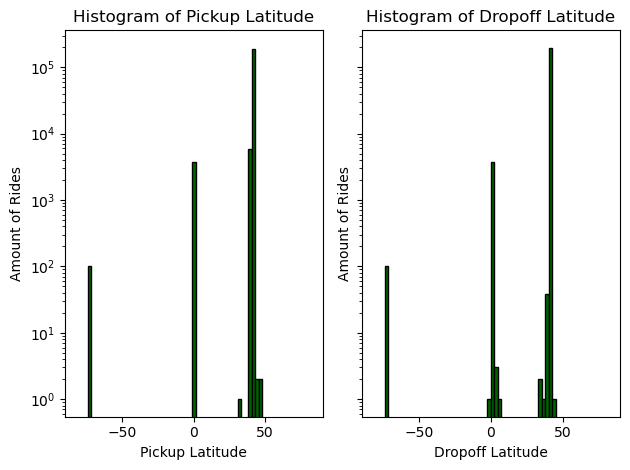

In [12]:
# histograms for pickup and dropoff latitude features
n_bins = 50
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(
    uber_df_['pickup_latitude'], 
    bins=n_bins,
    color='darkgreen',
    edgecolor='black'
)
axs[0].set_xlim(-90, 90)

axs[0].set_title('Histogram of Pickup Latitude')
axs[0].set_xlabel('Pickup Latitude')
axs[0].set_ylabel('Amount of Rides')
axs[0].set_yscale('log')

axs[1].hist(
    uber_df_['dropoff_latitude'], 
    bins=n_bins,
    color='darkgreen',
    edgecolor='black'
)
axs[1].set_xlim(-90, 90)

axs[1].set_title('Histogram of Dropoff Latitude')
axs[1].set_xlabel('Dropoff Latitude')
axs[1].set_ylabel('Amount of Rides')
axs[1].set_yscale('log')

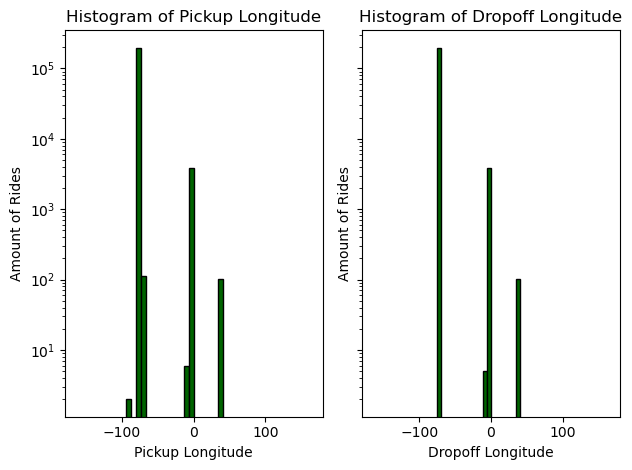

In [13]:
# histograms for pickup and dropoff longitude features
n_bins = 20
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(
    uber_df_['pickup_longitude'], 
    bins=n_bins,
    color='darkgreen',
    edgecolor='black'
)
axs[0].set_xlim(-180, 180)

axs[0].set_title('Histogram of Pickup Longitude')
axs[0].set_xlabel('Pickup Longitude')
axs[0].set_ylabel('Amount of Rides')
axs[0].set_yscale('log')

axs[1].hist(
    uber_df_['dropoff_longitude'], 
    bins=n_bins,
    color='darkgreen',
    edgecolor='black'
)
axs[1].set_xlim(-180, 180)

axs[1].set_title('Histogram of Dropoff Longitude')
axs[1].set_xlabel('Dropoff Longitude')
axs[1].set_ylabel('Amount of Rides')
axs[1].set_yscale('log')

As we see, for latitude, the most part of values are concentrated around the interval $[30, 50]$ - although there are also a lot of zero values -, while for longitude the values are concentrated around $[-60, -100]$ - and there are many zero values here too. This concentration indicates we are dealing with data from USA location. The limits (maximum and minimum) of USA latitude and longitude are:
- Minimum Latitude: Approximately $24.396308$ degrees North
- Maximum Latitude: Approximately $49.384358$ degrees North
- Minimum Longitude: Approximately $-125.000000$ degrees West
- Maximum Longitude: Approximately $-66.934570$ degrees West

To deal with the values that are outside the USA limits, we need to separate them in cases. They are: 
1) If `pickup_latitude`, `pickup_longitude`, `dropoff_latitude` and `dropoff_longitude` are all zero, we will drop this example as we do not have any geographical information about the ride;
2) To the other cases in which we have strange values, we need to specify the following: if the value is outside the USA limits, we will input the mean of the column for this value. 

#### Latitude and Longitude all zero

In [14]:
# all latitude and longitude feature being zero
uber_df_[
    (uber_df_.pickup_latitude == 0) &
    (uber_df_.pickup_longitude == 0) &
    (uber_df_.dropoff_latitude == 0) & 
    (uber_df_.dropoff_longitude == 0)
]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
7,2.5,2012-12-11 13:52:00 UTC,0.0,0.0,0.0,0.0,1
11,8.5,2011-05-23 22:15:00 UTC,0.0,0.0,0.0,0.0,1
65,6.0,2014-05-05 19:27:00 UTC,0.0,0.0,0.0,0.0,1
92,6.1,2011-12-02 14:07:00 UTC,0.0,0.0,0.0,0.0,1
120,6.5,2010-08-20 19:39:48 UTC,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...
199718,4.9,2011-08-19 07:16:00 UTC,0.0,0.0,0.0,0.0,1
199724,7.5,2013-10-11 11:25:41 UTC,0.0,0.0,0.0,0.0,1
199880,6.5,2014-02-22 06:45:46 UTC,0.0,0.0,0.0,0.0,1
199883,12.5,2012-09-10 17:39:00 UTC,0.0,0.0,0.0,0.0,2


In [15]:
# dropping the rows with latitude and longitude being zero
uber_df_ = (
    uber_df_
    .query(
        'pickup_longitude != 0' or 
        'pickup_latitude != 0' or 
        'dropoff_longitude != 0' or 
        'dropoff_latitude != 0'
    )
)

#### Latitude and Longitude outside the USA limits

Firstly, let us find out the mean of `latitude` and `longitude` features considering only the valid values, i.e, in which the values belong to USA territory.

In [16]:
# dictionary with the latitude and longitude values for the USA
valid_latitude_longitude_intervals = {
    'pickup_longitude': (-125, -67),
    'pickup_latitude': (24, 50),
    'dropoff_longitude': (-125, -67),
    'dropoff_latitude': (24, 50)
}

Now, we will replace all values that are outside these intervals for null values:

In [17]:
for col, (min_val, max_val) in valid_latitude_longitude_intervals.items():
    uber_df_[col] = (
        uber_df_[col]
        .apply(
            lambda x: x if min_val <= x <= max_val else np.nan
        )
    )

In [18]:
# mean values for latitude and longitude columns not considering null values 
mean_value_pickup_latitude = uber_df_.pickup_latitude.mean()
mean_value_pickup_longitude = uber_df_.pickup_longitude.mean()
mean_value_dropoff_latitude = uber_df_.dropoff_latitude.mean()
mean_value_dropoff_longitude = uber_df_.dropoff_longitude.mean()

Finally, the null values will be replaced by the mean values calculated above:

In [19]:
# replacing the null values by the mean of the column 
uber_df_.pickup_latitude = (
    uber_df_.pickup_latitude
    .fillna(
        mean_value_pickup_latitude,  
    )
)

uber_df_.pickup_longitude = (
    uber_df_.pickup_longitude
    .fillna(
        mean_value_pickup_longitude
    )
)

uber_df_.dropoff_latitude = (
    uber_df_.dropoff_latitude
    .fillna(
        mean_value_dropoff_latitude
    )
)

uber_df_.dropoff_longitude = (
    uber_df_.dropoff_longitude
    .fillna(
        mean_value_dropoff_longitude
    )
)

Let us analyze the histograms again to see if all we have done worked:

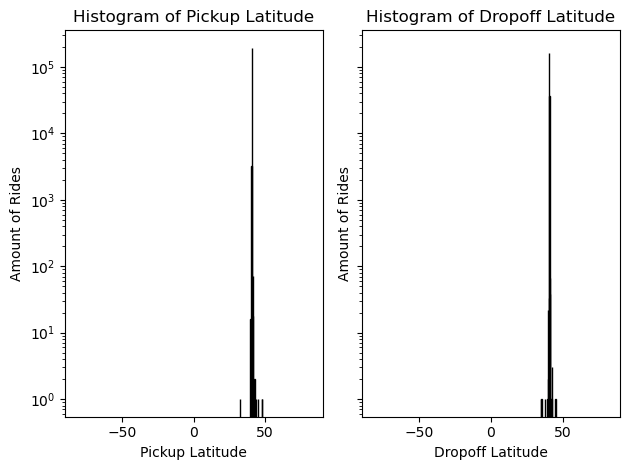

In [20]:
# histograms for pickup and dropoff latitude features
n_bins = 50
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(
    uber_df_['pickup_latitude'], 
    bins=n_bins,
    color='darkgreen',
    edgecolor='black'
)
axs[0].set_xlim(-90, 90)

axs[0].set_title('Histogram of Pickup Latitude')
axs[0].set_xlabel('Pickup Latitude')
axs[0].set_ylabel('Amount of Rides')
axs[0].set_yscale('log')

axs[1].hist(
    uber_df_['dropoff_latitude'], 
    bins=n_bins,
    color='darkgreen',
    edgecolor='black'
)
axs[1].set_xlim(-90, 90)

axs[1].set_title('Histogram of Dropoff Latitude')
axs[1].set_xlabel('Dropoff Latitude')
axs[1].set_ylabel('Amount of Rides')
axs[1].set_yscale('log')

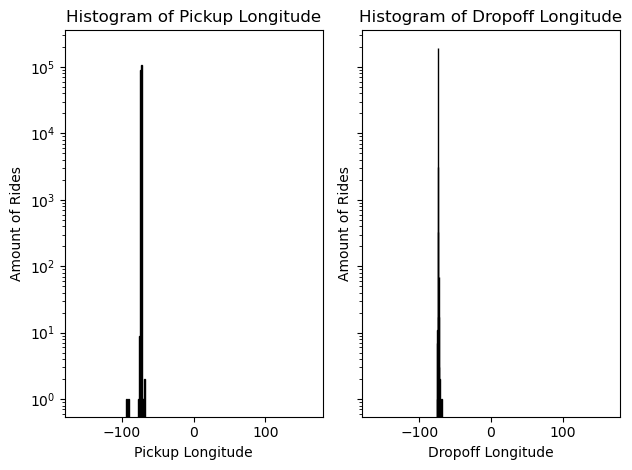

In [21]:
# histograms for pickup and dropoff longitude features
n_bins = 20
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(
    uber_df_['pickup_longitude'], 
    bins=n_bins,
    color='darkgreen',
    edgecolor='black'
)
axs[0].set_xlim(-180, 180)

axs[0].set_title('Histogram of Pickup Longitude')
axs[0].set_xlabel('Pickup Longitude')
axs[0].set_ylabel('Amount of Rides')
axs[0].set_yscale('log')

axs[1].hist(
    uber_df_['dropoff_longitude'], 
    bins=n_bins,
    color='darkgreen',
    edgecolor='black'
)
axs[1].set_xlim(-180, 180)

axs[1].set_title('Histogram of Dropoff Longitude')
axs[1].set_xlabel('Dropoff Longitude')
axs[1].set_ylabel('Amount of Rides')
axs[1].set_yscale('log')

Very good! Now we cleaned the data in a correct way. Let's save this cleaned dataframe to future use.

In [22]:
# saving the cleaned data
path_cleaned_data = '../../uber-fares-prediction/data/interim/'
uber_df_.to_csv(path_cleaned_data + 'uber_cleaned_data.csv')

## Separating Train and Test Sets

As in our data we do not have categorical features and we are not dealing with imbalanced problems, we can use a simple `train_test_split` to separate our data in train and test sets.

In [23]:
# creating train and test sets 
X = uber_df_.loc[:, uber_df_.columns != 'fare_amount']
y = uber_df_['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.3,
    random_state=42
)

In [24]:
# saving y_test set
X_train.to_csv('../../uber-fares-prediction/data/processed/uber_train_set.csv', index=False)
X_test.to_csv('../../uber-fares-prediction/data/processed/uber_validation_set.csv', index=False)
y_train.to_csv('../../uber-fares-prediction/data/processed/uber_validation_target.csv', index=False)
y_test.to_csv('../../uber-fares-prediction/data/processed/uber_test_set.csv', index=False)